## Intraday Mean Reversion Following Overnight Gaps: A Decile-Based Analysis Using High-Frequency Data
---

In [ ]:
# Core Libraries
import os
import glob
import ast
import calendar
import warnings
from collections import defaultdict
from datetime import datetime

# Data and Math
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore, f_oneway, ttest_1samp

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Stats and Modeling
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression

# Progress Bar
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:

# List your indices
indices = ['dax', 'ftse100', 'cac40', 'nifty', 'sensex', 'sp500', 'ndx', 'djia']

for index in indices:
    px_dir = os.path.join(BASE_DIR, index, 'px')
    files = glob.glob(f"{px_dir}/*.csv")

    for file in files:
        try:
            df = pd.read_csv(file)
            df['index'] = index
            df['source_file'] = os.path.basename(file)
            all_minute_data.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

df_minute_all = pd.concat(all_minute_data, ignore_index=True)
df_minute_all = df_minute_all.drop(columns=['Date'], errors='ignore')
df_minute_all.head(2)

,Datetime,Open,High,Low,Close,Adj Close,Volume,Symbol,index,source_file
0,2024-08-15 09:00:00+02:00,17980.4902,17980.4902,17979.0703,17979.0703,17979.0703,0,^GDAXI,dax,dax.minute.20240815.csv
1,2024-08-15 09:01:00+02:00,17979.9102,17979.9102,17959.7695,17959.7695,17959.7695,0,^GDAXI,dax,dax.minute.20240815.csv


Convert Prices and Volume columns to Numeric Type

In [ ]:

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df_minute_all[numeric_cols] = df_minute_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_minute_all.dropna(subset=numeric_cols + ['Datetime', 'Symbol'], inplace=True) # Drop NaN


Period of the data

In [ ]:

start_date = df_minute_all['Datetime'].min()
end_date = df_minute_all['Datetime'].max()

print(f"Date range in the data: {start_date} to {end_date}")


Date range in the data: 2023-06-01 08:00:00+01:00 to 2025-03-28 19:59:00+00:00


* The intraday minute-level data spans from **June 1, 2023** to **March 28, 2025** covering **22 months** period.

* The timestamps include timezone information (+00:00), which means they are in UTC.

List of indices in the data

In [ ]:

list(df_minute_all['Symbol'].unique())


['^GDAXI', '^FTSE', '^FCHI', '^NSEI', '^BSESN', '^GSPC', '^IXIC', '^DJI']

Sampling Frequency Check (per Symbol)

In [ ]:

df_minute_all['Datetime'] = pd.to_datetime(df_minute_all['Datetime'], utc=True)
def sampling_frequency(symbol_df):
    deltas = symbol_df["Datetime"].sort_values().diff().dropna()
    return deltas.value_counts().head(3)

sampling_check = df_minute_all.groupby("Symbol").apply(sampling_frequency)
sampling_check


Symbol  Datetime       
^BSESN  0 days 00:01:00    155438
        0 days 17:46:00       311
        0 days 00:02:00       190
^DJI    0 days 00:01:00    163740
        0 days 17:31:00       325
        0 days 00:02:00       250
^FCHI   0 days 00:01:00    220602
        0 days 00:02:00       504
        0 days 15:31:00       305
^FTSE   0 days 00:01:00    219482
        0 days 00:02:00       347
        0 days 15:31:00       339
^GDAXI  0 days 00:01:00    219589
        0 days 00:02:00       302
        0 days 15:33:00       125
^GSPC   0 days 00:01:00    164938
        0 days 17:31:00       329
        0 days 00:02:00       242
^IXIC   0 days 00:01:00    164521
        0 days 17:31:00       327
        0 days 00:02:00       265
^NSEI   0 days 00:01:00    156853
        0 days 17:46:00       315
        0 days 00:02:00       216
Name: count, dtype: int64

Keep Only Rows With Minute Interval on a Copy

In [ ]:

df_temp = df_minute_all.copy() # Copy of the data
df_temp = df_temp.sort_values(['Symbol', 'Datetime'])
initial_counts = df_temp['Symbol'].value_counts().sort_index()

# Filter rows to keep only those matching the dominant delta per symbol
def filter_by_dominant_delta(symbol_df):
    symbol_df = symbol_df.sort_values('Datetime')
    delta = symbol_df['Datetime'].diff()
    mode_delta = delta.mode().iloc[0]  # most common delta
    mask = delta.isna() | (delta == mode_delta)  # keep first row and those matching mode
    return symbol_df[mask]

# Apply filtering to the copy and get filtered counts per symbol
df_temp_filtered = df_temp.groupby('Symbol', group_keys=False).apply(filter_by_dominant_delta).reset_index(drop=True)

filtered_counts = df_temp_filtered['Symbol'].value_counts().sort_index()
dropped_counts = initial_counts - filtered_counts
dropped_percent = (dropped_counts / initial_counts * 100).round(2)

# Create summary table
summary_table = pd.DataFrame({
    'Symbol': initial_counts.index,
    'Initial Count': initial_counts.values,
    'Filtered Count': filtered_counts.values,
    'Percent Dropped': dropped_percent.values
})

print(tabulate(summary_table, headers='keys', tablefmt='grid', showindex=False))



+----------+-----------------+------------------+-------------------+
| Symbol   |   Initial Count |   Filtered Count |   Percent Dropped |
+==========+=================+==================+===================+
| ^BSESN   |          156080 |           155439 |              0.41 |
+----------+-----------------+------------------+-------------------+
| ^DJI     |          164449 |           163741 |              0.43 |
+----------+-----------------+------------------+-------------------+
| ^FCHI    |          221605 |           220603 |              0.45 |
+----------+-----------------+------------------+-------------------+
| ^FTSE    |          220310 |           219483 |              0.38 |
+----------+-----------------+------------------+-------------------+
| ^GDAXI   |          220367 |           219590 |              0.35 |
+----------+-----------------+------------------+-------------------+
| ^GSPC    |          165638 |           164939 |              0.42 |
+----------+--------

Why skipping cleaning makes sense:
1. The dominant frequency is already 1-minute. The sampling check confirms that over 99% of the data for each index is sampled at 1-minute intervals. That means the dataset is already highly consistent without intervention.

2. Cleaning removes valid data. Filtering to keep only the dominant delta ended up:

* Dropping ~0.4% of the rows, mostly valid first rows of the day

* And still leaving some “irregular” gaps (e.g. transitions between sessions)

* So the cleaning introduces loss without eliminating the perceived issue.

3. Returns are computed within each day. Intraday return and decile-based strategies:

* Group by date

* Operate on each day independently

That naturally contains the effect of session breaks, so those inter-day gaps do not affect the logic.

Months With Less Data

In [ ]:

df_minute_all['date'] = pd.to_datetime(df_minute_all['Datetime']).dt.date
df_minute_all['month'] = pd.to_datetime(df_minute_all['Datetime']).dt.to_period('M')
daily_counts = df_minute_all.groupby('month')['date'].nunique()

# Identify months with fewer than 15 valid trading days
months_to_exclude = daily_counts[daily_counts < 15].index
print("Months to exclude:", months_to_exclude.tolist())


Months to exclude: [Period('2025-02', 'M'), Period('2025-03', 'M')]


Filter out rows where the month is in the exclusion list


In [ ]:

df_minute_all = df_minute_all[~df_minute_all['month'].isin(months_to_exclude)].copy()


Extract Local Time

In [ ]:

# Example timezone mapping (adjust as needed)
symbol_timezone = {
    '^GSPC': 'America/New_York',
    '^IXIC': 'America/New_York',
    '^DJI': 'America/New_York',
    '^FTSE': 'Europe/London',
    '^FCHI': 'Europe/Paris',
    '^GDAXI': 'Europe/Berlin',
    '^NSEI': 'Asia/Kolkata',
    '^BSESN': 'Asia/Kolkata',
}

region_map = {
    '^GDAXI': 'Europe',
    '^FTSE': 'Europe',
    '^FCHI': 'Europe',
    '^NSEI': 'Asia',
    '^BSESN': 'Asia',
    '^GSPC': 'US',
    '^IXIC': 'US',
    '^DJI': 'US'
}

# Step 2: Create a Local_Timestamp column as a copy of Datetime (to preserve dtype)
df_minute_all['Local_Timestamp'] = df_minute_all['Datetime']

# Apply timezone conversion by symbol using a loop and tz_convert
for symbol, tz in symbol_timezone.items():
    mask = df_minute_all['Symbol'] == symbol
    df_minute_all.loc[mask, 'Local_Timestamp'] = (
        df_minute_all.loc[mask, 'Datetime'].dt.tz_convert(tz)
    )

# Now safely extract local_date
df_minute_all['local_date'] = df_minute_all['Local_Timestamp'].dt.date
df_minute_all['Region'] = df_minute_all['Symbol'].map(region_map)

# Compute minute column per (Symbol, local_date)
df_minute_all = df_minute_all.sort_values(['Symbol', 'local_date', 'Local_Timestamp'])
df_minute_all['minute'] = (df_minute_all.groupby(['Symbol', 'local_date']).cumcount() + 1).astype('Int64')


In [ ]:

df_minute_all['date'] = df_minute_all['Datetime'].dt.date

# Group and summarize
valid_days = df_minute_all.groupby(['Symbol', 'date']).size().reset_index(name='minute_count')
summary = valid_days.groupby('Symbol')['minute_count'].agg(['count', 'mean', 'std'])
summary['percent_complete'] = (summary['count'] / valid_days['date'].nunique()) * 100
summary = summary.round(2)
summary_reset = summary.reset_index()

print(tabulate(summary_reset, headers='keys', tablefmt='grid'))


+----+----------+---------+--------+-------+--------------------+
|    | Symbol   |   count |   mean |   std |   percent_complete |
+====+==========+=========+========+=======+====================+
|  0 | ^BSESN   |     405 | 374.27 |  1.55 |              93.75 |
+----+----------+---------+--------+-------+--------------------+
|  1 | ^DJI     |     414 | 386.87 | 19.94 |              95.83 |
+----+----------+---------+--------+-------+--------------------+
|  2 | ^FCHI    |     425 | 507.05 | 14.12 |              98.38 |
+----+----------+---------+--------+-------+--------------------+
|  3 | ^FTSE    |     423 | 506.36 | 23.9  |              97.92 |
+----+----------+---------+--------+-------+--------------------+
|  4 | ^GDAXI   |     423 | 506.56 | 14.57 |              97.92 |
+----+----------+---------+--------+-------+--------------------+
|  5 | ^GSPC    |     417 | 386.93 | 19.85 |              96.53 |
+----+----------+---------+--------+-------+--------------------+
|  6 | ^IX

Price Trajectories Around Market Opens and Closes

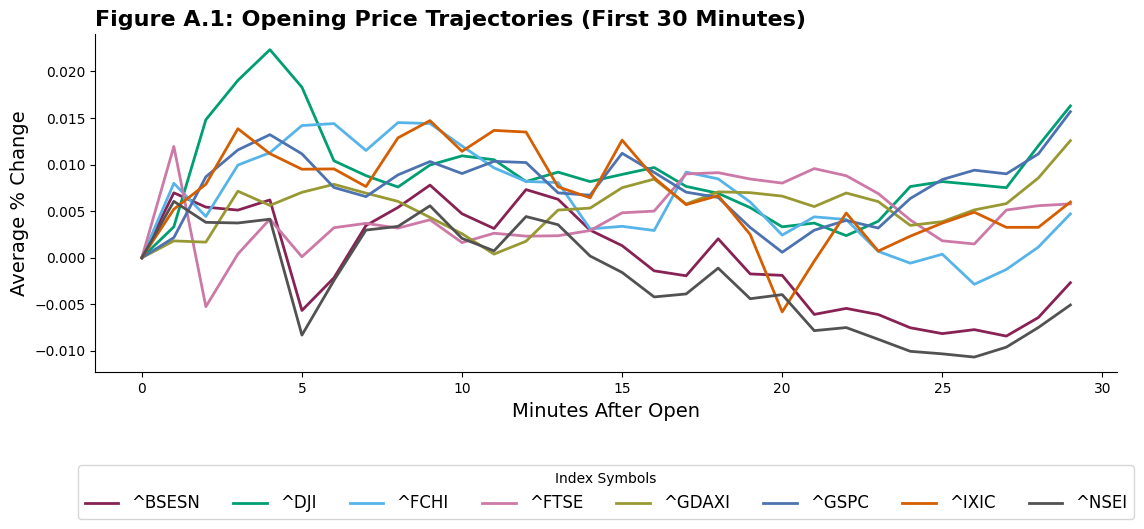

In [ ]:

# Sort and normalize minutes
df_minute_all = df_minute_all.sort_values(['Symbol', 'date', 'Datetime'])
df_minute_all['minute_normalized'] = df_minute_all.groupby(['Symbol', 'date']).cumcount() + 1

# OPEN WINDOW ANALYSIS

# Filter first 30 minutes
open_window = df_minute_all[df_minute_all['minute_normalized'].between(1, 30)].copy()

# Get first close price of the day per symbol and date
first_close = (
    df_minute_all[df_minute_all['minute_normalized'] == 1]
    .groupby(['Symbol', 'date'])['Close']
    .first()
    .rename('first_close')
    .reset_index()
)

# Merge and compute relative close
open_window = open_window.merge(first_close, on=['Symbol', 'date'], how='left')
open_window['relative_close'] = open_window['Close'] / open_window['first_close'] - 1
open_window['minute_from_open'] = open_window['minute_normalized'] - 1

# Compute mean % change per minute and symbol
open_trajectory = (
    open_window.groupby(['Symbol', 'minute_from_open'])['relative_close']
    .mean()
    .unstack(0)
)

# Custom professional color palette
colors = {
    '^GSPC': '#4C72B0',    # Slate Blue
    '^IXIC': '#D55E00',    # Orange
    '^DJI': '#009E73',     # Forest Green
    '^FTSE': '#CC79A7',    # Crimson
    '^FCHI': '#56B4E9',    # Teal
    '^GDAXI': '#999933',   # Olive Green
    '^NSEI': '#525252',    # Charcoal Gray
    '^BSESN': '#882255'    # Maroon
}

plt.figure(figsize=(12, 6))
for symbol in open_trajectory.columns:
    plt.plot(open_trajectory.index, open_trajectory[symbol] * 100,
             label=symbol, color=colors[symbol], linewidth=2)

plt.xlabel('Minutes After Open', fontsize=14)
plt.ylabel('Average % Change', fontsize=14)

# Style cleanup
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid(False)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=8,
    fontsize=12,
    title='Index Symbols'
)

# Add left-aligned bold figure title
plt.title('Figure A.1: Opening Price Trajectories (First 30 Minutes)',
          fontsize=16, fontweight='bold', loc='left')

plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.figtext(0.5, -0.05,
#            "This chart displays the average % change in normalized close prices for 8 global indices during the first 30 minutes of trading",
#            wrap=True, horizontalalignment='center', fontsize=14)

plt.show()


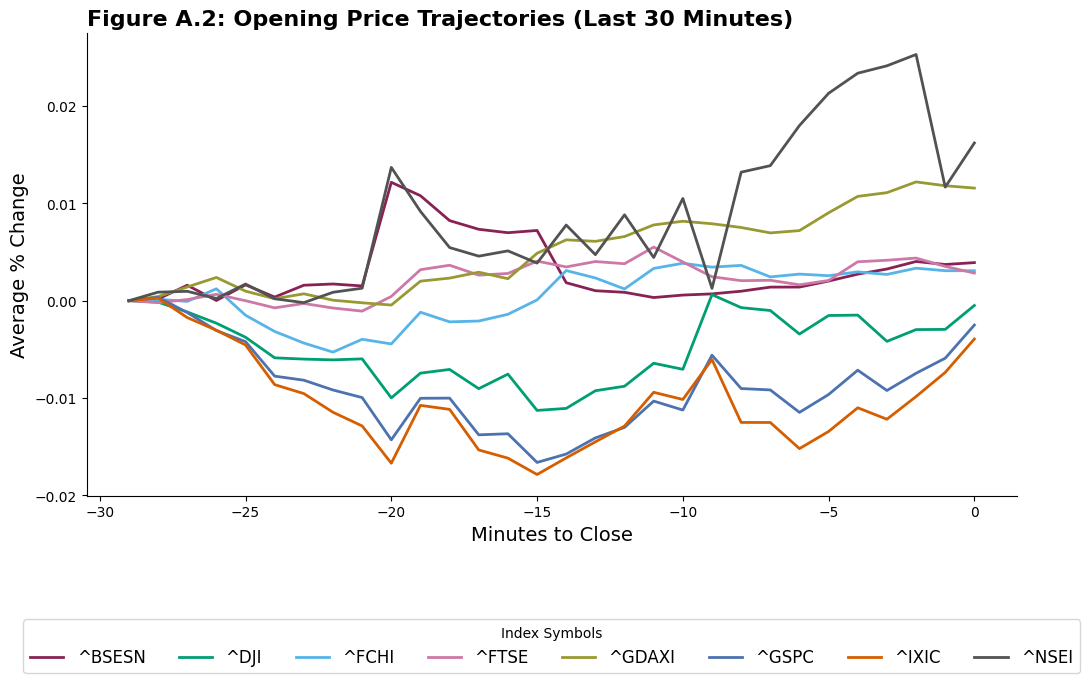

In [ ]:

# CLOSE WINDOW ANALYSIS

# Get total minutes per day
df_minute_all['max_minute'] = df_minute_all.groupby(['Symbol', 'date'])['minute_normalized'].transform('max')
df_minute_all['minute_to_close'] = df_minute_all['minute_normalized'] - df_minute_all['max_minute']

# Filter last 30 minutes
close_window = df_minute_all[df_minute_all['minute_to_close'].between(-29, 0)].copy()

# Normalize by close at start of close window
first_close_closewin = (
    close_window[close_window['minute_to_close'] == -29]
    .groupby(['Symbol', 'date'])['Close']
    .first()
    .rename('base_close')
    .reset_index()
)

close_window = close_window.merge(first_close_closewin, on=['Symbol', 'date'], how='left')
close_window['relative_close'] = close_window['Close'] / close_window['base_close'] - 1

# Compute mean % change per minute and symbol
close_trajectory = (
    close_window.groupby(['Symbol', 'minute_to_close'])['relative_close']
    .mean()
    .unstack(0)
)

plt.figure(figsize=(12, 6))
for symbol in close_trajectory.columns:
    plt.plot(close_trajectory.index, close_trajectory[symbol] * 100,
             label=symbol, color=colors[symbol], linewidth=2)

plt.xlabel('Minutes to Close', fontsize=14)
plt.ylabel('Average % Change', fontsize=14)

# Style cleanup
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid(False)

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=8,
    fontsize=12,
    title='Index Symbols'
)
# Add left-aligned bold figure title
plt.title('Figure A.2: Opening Price Trajectories (Last 30 Minutes)',
          fontsize=16, fontweight='bold', loc='left')

#plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.figtext(0.5, -0.05, "This plot shows the average price trajectory in the final 30 minutes, normalized from the start of the window, enabling cross-market comparison.",
#            wrap=True, horizontalalignment='center', fontsize=14)
plt.show()


Compute Overnight and Intraday Return and Deciles

In [ ]:

# Daily last close and first open
daily_close = (
    df_minute_all.groupby(['Symbol', 'date'])['Close']
    .last()
    .rename('prev_close')
    .reset_index()
)

daily_open = (
    df_minute_all.groupby(['Symbol', 'date'])['Open']
    .first()
    .rename('open_today')
    .reset_index()
)

# Shift prev_close forward by one day for each symbol
daily_close['next_date'] = daily_close.groupby('Symbol')['date'].shift(-1)

# Merge for overnight return
overnight_df = pd.merge(
    daily_open,
    daily_close[['Symbol', 'next_date', 'prev_close']],
    left_on=['Symbol', 'date'],
    right_on=['Symbol', 'next_date'],
    how='inner'
)

# Compute overnight return
overnight_df['overnight_return'] = (overnight_df['open_today'] / overnight_df['prev_close']) - 1
overnight_df = overnight_df[['Symbol', 'date', 'prev_close', 'open_today', 'overnight_return']]

# Assign deciles by overnight return
overnight_df['decile'] = (
    overnight_df.groupby('date')['overnight_return']
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))
)

# Merge deciles into main dataframe
df_minute_all = df_minute_all.merge(
    overnight_df[['Symbol', 'date', 'decile']],
    on=['Symbol', 'date'],
    how='left'
)

# Intraday return
open_price = df_minute_all.groupby(['Symbol', 'date'])['Open'].first()
close_price = df_minute_all.groupby(['Symbol', 'date'])['Close'].last()

intraday_return = ((close_price / open_price) - 1).reset_index()
intraday_return.columns = ['Symbol', 'date', 'intraday_return']

# Merge in overnight return and decile
intraday_return = intraday_return.merge(
    overnight_df[['Symbol', 'date', 'decile', 'overnight_return']],
    on=['Symbol', 'date'],
    how='left'
)


Merge Intraday Return Back to df_minute_all

In [ ]:

df_minute_all = df_minute_all.merge(
    intraday_return[['Symbol', 'date', 'intraday_return', 'overnight_return']],
    on=['Symbol', 'date'], how='left'
)


In [ ]:
df_minute_all.tail()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Symbol,index,source_file,...,Local_Timestamp,local_date,Region,minute,minute_normalized,max_minute,minute_to_close,decile,intraday_return,overnight_return
1431046,2025-01-31 09:55:00+00:00,23521.0508,23521.6504,23517.3496,23519.4492,23519.4492,0,^NSEI,nifty,nifty.minute.20250131.csv,...,2025-01-31 09:55:00+00:00,2025-01-31,Asia,371,371,375,-4,1.0,0.010141,-0.000015
1431047,2025-01-31 09:56:00+00:00,23518.5996,23522.4004,23518.4004,23521.5508,23521.5508,0,^NSEI,nifty,nifty.minute.20250131.csv,...,2025-01-31 09:56:00+00:00,2025-01-31,Asia,372,372,375,-3,1.0,0.010141,-0.000015
1431048,2025-01-31 09:57:00+00:00,23522.1992,23530.7500,23520.8008,23530.4004,23530.4004,0,^NSEI,nifty,nifty.minute.20250131.csv,...,2025-01-31 09:57:00+00:00,2025-01-31,Asia,373,373,375,-2,1.0,0.010141,-0.000015
1431049,2025-01-31 09:58:00+00:00,23529.1504,23541.5000,23529.1504,23536.9004,23536.9004,0,^NSEI,nifty,nifty.minute.20250131.csv,...,2025-01-31 09:58:00+00:00,2025-01-31,Asia,374,374,375,-1,1.0,0.010141,-0.000015
1431050,2025-01-31 09:59:00+00:00,23537.8008,23546.4004,23529.4492,23533.8496,23533.8496,0,^NSEI,nifty,nifty.minute.20250131.csv,...,2025-01-31 09:59:00+00:00,2025-01-31,Asia,375,375,375,0,1.0,0.010141,-0.000015


### Analysis

\


#### Decile Gap Analysis (Lou et al.’s Sentiment Measure)
Compute Overnight Returns (Previous Close to Market Open)


\

Calculate Overnight and Intraday return Statistics

In [ ]:

# Stats
valid_data = df_minute_all[['decile', 'intraday_return', 'overnight_return']].dropna()

decile_overnight_stats = (
    valid_data.groupby('decile')['overnight_return']
    .agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    .reset_index()
)
decile_overnight_stats = decile_overnight_stats.round(4)

decile_stats = (
    valid_data.groupby('decile')['intraday_return']
    .agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    .reset_index()
)
decile_stats = decile_stats.round(4)


# Overnight Return Stats
print("=== Overnight Return Statistics by Decile ===")
print(tabulate(
    decile_overnight_stats,
    headers='keys',
    tablefmt='grid',
    showindex=False,
    floatfmt=".4f"
), "\n")

# Intraday Return Stats
print("=== Intraday Return Statistics by Decile ===")
print(tabulate(
    decile_stats,
    headers='keys',
    tablefmt='grid',
    showindex=False,
    floatfmt=".4f"
))


=== Overnight Return Statistics by Decile ===
+----------+-------------+---------+--------+----------+---------+--------+
|   decile |       count |    mean |    std |   median |     min |    max |
+==========+=============+=========+========+==========+=========+========+
|   0.0000 | 192470.0000 | -0.0037 | 0.0052 |  -0.0021 | -0.0627 | 0.0125 |
+----------+-------------+---------+--------+----------+---------+--------+
|   1.0000 | 180948.0000 | -0.0022 | 0.0038 |  -0.0012 | -0.0415 | 0.0059 |
+----------+-------------+---------+--------+----------+---------+--------+
|   2.0000 | 170259.0000 | -0.0009 | 0.0029 |  -0.0003 | -0.0274 | 0.0068 |
+----------+-------------+---------+--------+----------+---------+--------+
|   3.0000 |  13883.0000 |  0.0000 | 0.0023 |  -0.0003 | -0.0062 | 0.0056 |
+----------+-------------+---------+--------+----------+---------+--------+
|   4.0000 | 173136.0000 |  0.0001 | 0.0026 |   0.0002 | -0.0207 | 0.0084 |
+----------+-------------+---------+------

Visualize the Results

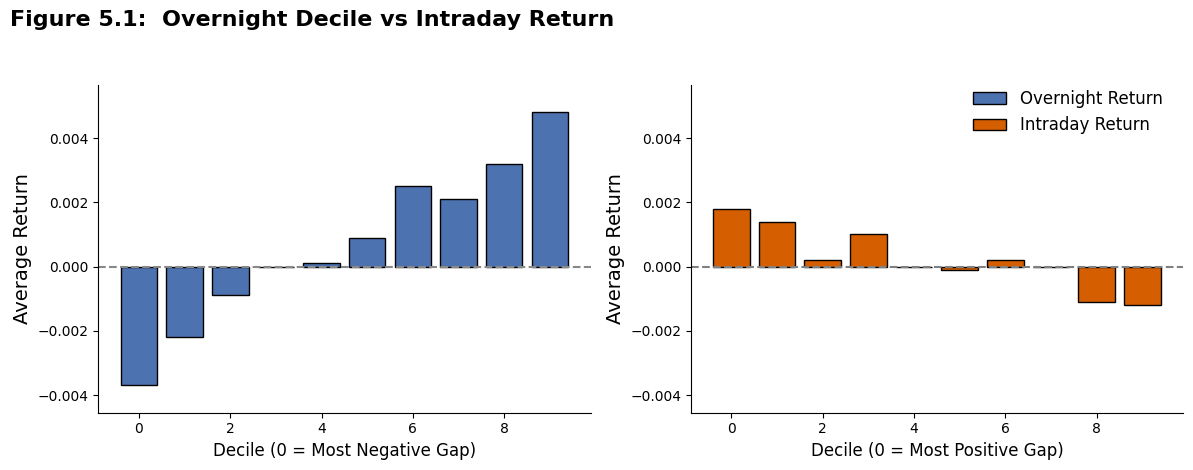

In [ ]:

overnight_mean = decile_overnight_stats['mean']
intraday_mean = decile_stats['mean']
combined_min = min(overnight_mean.min(), intraday_mean.min())
combined_max = max(overnight_mean.max(), intraday_mean.max())
y_padding = 0.1 * (combined_max - combined_min)
y_lim = (combined_min - y_padding, combined_max + y_padding)

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Style helper
def clean_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.grid(False)

# Plot: Average Overnight Return
bars1 = axes[0].bar(
    decile_overnight_stats['decile'],
    decile_overnight_stats['mean'],
    color='#4C72B0',
    edgecolor='#000000',
    label='Overnight Return'
)
axes[0].axhline(0, color='#888888', linestyle='--')
axes[0].set_xlabel('Decile (0 = Most Negative Gap)', fontsize=12)
axes[0].set_ylabel('Average Return', fontsize=14)
axes[0].set_ylim(y_lim)
clean_axes(axes[0])

# Plot: Average Intraday Return
bars2 = axes[1].bar(
    decile_stats['decile'],
    decile_stats['mean'],
    color='#D55E00',
    edgecolor='#000000',
    label='Intraday Return'
)
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_xlabel('Decile (0 = Most Positive Gap)', fontsize=12)
axes[1].set_ylabel('Average Return', fontsize=14)
axes[1].set_ylim(y_lim)
clean_axes(axes[1])

# Add one legend below centered for both bars
handles = [bars1[0], bars2[0]]
labels = ['Overnight Return', 'Intraday Return']
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.8, 0.85), ncol=1, frameon=False, fontsize=12)

# Add figure title aligned left
fig.suptitle('Figure 5.1:  Overnight Decile vs Intraday Return', x=0.01, ha='left', fontsize=16, fontweight='bold')

# Caption below
#fig.text(0.5, -0.05,
#         "Average returns by overnight gap decile show strong mean reversion—stocks with large positive gaps underperform intraday, while negative-gap stocks tend to rebound.",
#         wrap=True, horizontalalignment='center', fontsize=14)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()


### Long-Short Portfolio (Annualized Performance of ETF Portfolio)
\
Construct Long-Short Portfolio (Decile 10 - Decile 1)

In [ ]:

# Long-short return = Decile 9 (top 10%) minus Decile 0 (bottom 10%)
decile_returns = intraday_return.groupby(['date', 'decile'])['intraday_return'].mean().unstack()
decile_returns['decile_gap'] = decile_returns[9] - decile_returns[0]


Output Summary Statistics and T-Test

In [ ]:

# One-sample t-test for H0: mean = 0
t_stat, p_value = stats.ttest_1samp(decile_returns['decile_gap'].dropna(), 0)

# Summary stats
summary_stats = decile_returns['decile_gap'].describe().to_frame().T.round(4)

# Combine results into a table
results_table = [
    ["Sample Size (n)", summary_stats['count'].values[0]],
    ["Mean", summary_stats['mean'].values[0]],
    ["Std Dev", summary_stats['std'].values[0]],
    ["Min", summary_stats['min'].values[0]],
    ["25%", summary_stats['25%'].values[0]],
    ["Median", summary_stats['50%'].values[0]],
    ["75%", summary_stats['75%'].values[0]],
    ["Max", summary_stats['max'].values[0]],
    ["", ""],  # Spacer
    ["T-statistic", f"{t_stat:.4f}"],
    ["p-value", f"{p_value:.4f}"]
]

# Print formatted table
print(tabulate(results_table, headers=["Statistic", "Value"], tablefmt="grid"))


+-----------------+---------+
| Statistic       | Value   |
+=================+=========+
| Sample Size (n) | 431.0   |
+-----------------+---------+
| Mean            | -0.0028 |
+-----------------+---------+
| Std Dev         | 0.0097  |
+-----------------+---------+
| Min             | -0.0523 |
+-----------------+---------+
| 25%             | -0.008  |
+-----------------+---------+
| Median          | -0.0027 |
+-----------------+---------+
| 75%             | 0.0031  |
+-----------------+---------+
| Max             | 0.0399  |
+-----------------+---------+
|                 |         |
+-----------------+---------+
| T-statistic     | -5.9559 |
+-----------------+---------+
| p-value         | 0.0000  |
+-----------------+---------+


Explore robustness

\
Let’s proceed by segmenting the decile gap analysis by **region**, **index type**, and **volatility regime**.

\
By Region

In [ ]:

def compute_region_long_short(df_region):
    """
    Computes daily long-short returns (Decile 9 - Decile 0) for a pre-ranked region.
    Assumes 'decile' and 'intraday_return' columns already exist.
    """
    daily_long = df_region[df_region['decile'] == 9].groupby('date')['intraday_return'].mean()
    daily_short = df_region[df_region['decile'] == 0].groupby('date')['intraday_return'].mean()
    decile_gap = (daily_long - daily_short).dropna()
    return decile_gap

# Initialize results storage
results_region = []

# Process each region
for region, group in df_minute_all.groupby("Region"):
    decile_gap_returns = compute_region_long_short(group)

    # Statistics
    stat = decile_gap_returns.describe()
    t_stat, p_value = ttest_1samp(decile_gap_returns, 0)

    results_region.append({
        "Region": region,
        "Mean Return": stat["mean"],
        "Std Dev": stat["std"],
        "T-Stat": t_stat,
        "P-Value": p_value
    })

# Convert to DataFrame and format
df_region_summary = pd.DataFrame(results_region)
formatted_df = df_region_summary.copy()
formatted_df['Mean Return'] = formatted_df['Mean Return'].map('{:.4f}'.format)
formatted_df['Std Dev'] = formatted_df['Std Dev'].map('{:.4f}'.format)
formatted_df['T-Stat'] = formatted_df['T-Stat'].map('{:.3f}'.format)
formatted_df['P-Value'] = formatted_df['P-Value'].apply(
    lambda x: '{:.4f}'.format(x) if x >= 0.0001 else '<0.0001'
)

# Print results
print(tabulate(
    formatted_df,
    headers='keys',
    tablefmt='grid',
    showindex=False,
    stralign='right',
    numalign='right'
))




+----------+---------------+-----------+----------+-----------+
|   Region |   Mean Return |   Std Dev |   T-Stat |   P-Value |
+==========+===============+===========+==========+===========+
|     Asia |       -0.0023 |    0.0003 |   -9.444 |    0.0672 |
+----------+---------------+-----------+----------+-----------+
|   Europe |       -0.0044 |    0.0067 |   -4.625 |   <0.0001 |
+----------+---------------+-----------+----------+-----------+
|       US |       -0.0002 |    0.0098 |   -0.077 |    0.9395 |
+----------+---------------+-----------+----------+-----------+


By Volatility Regime
* Classify days (or periods) into Low, Medium, and High volatility regimes based on realized volatility (standard deviation of returns) from previous days.


  * Compute daily volatility from intraday returns or daily returns.

  * Use quantiles (bottom 33% = Low, middle 33% = Medium, top 33% = High volatility).

In [ ]:

# Compute daily average volatility and classify into terciles
df_minute_all['daily_volatility'] = (df_minute_all['High'] - df_minute_all['Low']) / df_minute_all['Open']
daily_vol = df_minute_all.groupby('date')['daily_volatility'].mean().reset_index()
daily_vol['Volatility_Regime'] = pd.qcut(
    daily_vol['daily_volatility'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# Merge volatility regime back to the full minute-level DataFrame
df_minute_all = df_minute_all.merge(
    daily_vol[['date', 'Volatility_Regime']],
    on='date',
    how='left'
)

# Prepare daily decile returns
decile_returns = (
    df_minute_all.groupby(['date', 'decile'])['intraday_return']
    .mean()
    .unstack()
    .reset_index()
    .rename_axis(None, axis=1)
)

# Calculate decile return spread (top minus bottom)
decile_returns['decile_gap'] = decile_returns[9] - decile_returns[0]
merged_data = pd.merge(
    decile_returns,
    daily_vol[['date', 'Volatility_Regime']],
    on='date',
    how='left'
)

# Analyze decile gaps by volatility regime
results_by_vol = []

for vol in ['Low', 'Medium', 'High']:
    subset = merged_data[merged_data['Volatility_Regime'] == vol]['decile_gap'].dropna()

    if len(subset) == 0:
        print(f"No data for volatility regime: {vol}")
        continue

    desc = subset.describe().round(4)
    t_stat, p_value = stats.ttest_1samp(subset.to_numpy(), 0)

    results_by_vol.append([
        vol,
        int(desc['count']),
        float(desc['mean']),
        float(desc['std']),
        f"{t_stat:.4f}",
        f"{p_value:.4f}"
    ])

if results_by_vol:
    headers = ["Volatility", "n", "Mean", "Std Dev", "T-stat", "P-value"]
    print(tabulate(results_by_vol, headers=headers, tablefmt="grid"))
else:
    print("No valid results - check your data and decile calculations")


+--------------+-----+---------+-----------+----------+-----------+
| Volatility   |   n |    Mean |   Std Dev |   T-stat |   P-value |
+==============+=====+=========+===========+==========+===========+
| Low          | 144 | -0.0009 |    0.0065 |  -1.75   |    0.0823 |
+--------------+-----+---------+-----------+----------+-----------+
| Medium       | 143 | -0.0027 |    0.0093 |  -3.5469 |    0.0005 |
+--------------+-----+---------+-----------+----------+-----------+
| High         | 144 | -0.0047 |    0.0122 |  -4.5799 |    0      |
+--------------+-----+---------+-----------+----------+-----------+


By Time of Day

Check whether returns vary by time of day — e.g., do certain deciles of overnight return lead to predictable behavior at specific times like market open, midday, or close? *When during the day is the overnight signal strongest — at the open? midday?*


\

Filter to valid rows (with overnight_return and decile)

In [ ]:

# Convert time to minutes since midnight
def time_to_minutes(t):
    return t.hour * 60 + t.minute

df_minute_all['time_only'] = df_minute_all['Datetime'].dt.time
df_minute_all['minute_int'] = df_minute_all['time_only'].apply(time_to_minutes)

# Define time-of-day segments based on minutes since midnight
def time_bucket(minutes):
    if pd.isna(minutes):
        return np.nan
    if minutes < 10*60 + 30:  # Before 10:30
        return 'Open'
    elif minutes < 14*60 + 30:  # Before 2:30 PM
        return 'Midday'
    else:
        return 'Close'

df_minute_all['time_bucket'] = df_minute_all['minute_int'].apply(time_bucket)

# Group by date, decile, and time bucket
intraday_return = df_minute_all[['date', 'decile', 'intraday_return', 'time_bucket']].dropna()
bucketed_returns = (
    intraday_return.groupby(['date', 'time_bucket', 'decile'])['intraday_return']
    .mean().unstack(level='decile')
)

# Compute long-short return (decile 9 - decile 0)
bucketed_returns['decile_gap'] = bucketed_returns[9] - bucketed_returns[0]

# Run stats per time_bucket
results = []
for bucket in bucketed_returns.index.get_level_values('time_bucket').unique():
    gap_series = bucketed_returns.xs(bucket, level='time_bucket')['decile_gap'].dropna()
    t_stat, p_val = stats.ttest_1samp(gap_series.to_numpy(), 0)
    summary = gap_series.describe().round(4)
    results.append([
        bucket,
        len(gap_series),
        summary['mean'],
        summary['std'],
        f"{t_stat:.4f}",
        f"{p_val:.4f}"
    ])

# Format as table
headers = ["Time Bucket", "n", "Mean", "Std", "t-stat", "p-value"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+---------------+-----+---------+--------+----------+-----------+
| Time Bucket   |   n |    Mean |    Std |   t-stat |   p-value |
+===============+=====+=========+========+==========+===========+
| Close         | 247 | -0.0032 | 0.01   |  -5.0639 |    0      |
+---------------+-----+---------+--------+----------+-----------+
| Midday        | 181 | -0.0043 | 0.0101 |  -5.7263 |    0      |
+---------------+-----+---------+--------+----------+-----------+
| Open          | 140 | -0.0018 | 0.008  |  -2.7441 |    0.0069 |
+---------------+-----+---------+--------+----------+-----------+


In [ ]:

# Keep only valid rows and assign deciles of overnight return
df_valid = df_minute_all[df_minute_all['overnight_return'].notna()].copy()
df_valid['overnight_decile'] = pd.qcut(df_valid['overnight_return'], 10, labels=False)

# Compute % change from first minute of the day for each symbol-date
df_valid['pct_change_from_open'] = (
    df_valid.groupby(['Symbol', 'date'])['Close']
    .transform(lambda x: x / x.iloc[0] - 1)
)


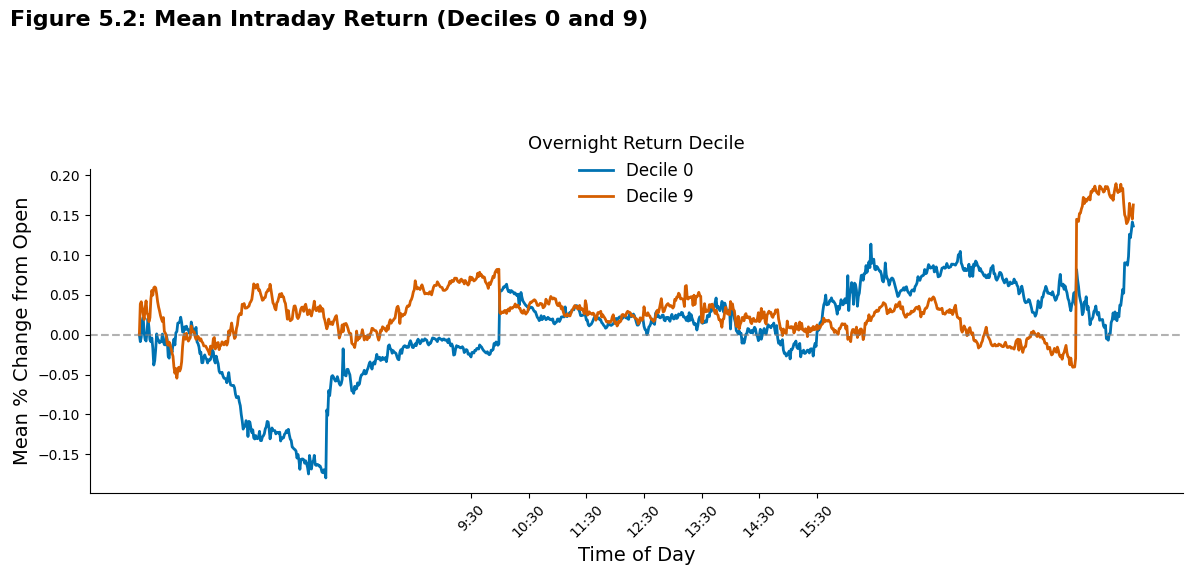

In [ ]:

df_valid['minute_int'] = df_valid['time_only'].apply(lambda t: t.hour * 60 + t.minute)

minute_returns = (
    df_valid
    .dropna(subset=['overnight_decile', 'pct_change_from_open'])
    .groupby(['minute_int', 'overnight_decile'])['pct_change_from_open']
    .mean()
    .unstack(level='overnight_decile')
)

deciles_to_plot = [0, 9]
colors = {0: '#0072B2', 9: '#D55E00'}

fig, ax = plt.subplots(figsize=(12, 6))

for decile in deciles_to_plot:
    ax.plot(
        minute_returns.index,
        minute_returns[decile] * 100,
        label=f'Decile {decile}',
        color=colors[decile],
        linewidth=2
    )

# X-axis formatting
market_open = 9.5 * 60
market_close = 16 * 60
time_ticks = np.arange(market_open, market_close + 30, 60)
time_labels = [f"{int(m // 60)}:{int(m % 60):02d}" for m in time_ticks]
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels, rotation=45)

# Axes labels and formatting
ax.set_ylabel('Mean % Change from Open', fontsize=14)
ax.set_xlabel('Time of Day', fontsize=14)
ax.axhline(0, color='gray', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Legend
ax.legend(
    title='Overnight Return Decile',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=1,
    frameon=False,
    fontsize=12,
    title_fontsize=13
)

# Title (left-aligned, bold figure number)
fig.suptitle('Figure 5.2: Mean Intraday Return (Deciles 0 and 9)',
             x=0.01, ha='left', fontsize=16, fontweight='bold')

# Caption
#fig.text(0.5, -0.05,
#         "Intraday return paths for extreme overnight deciles reveal that negative-gap stocks rise during the day, while positive-gap stocks often fade—supporting intraday mean reversion.",
#         wrap=True, horizontalalignment='center', fontsize=14)

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()


Pattern Persistency Analysis (Decile Gap over Fixed Intervals)

This focuses on robustness of the decile effect to different intraday windows. *How long into the day does the overnight signal persist before fading?*


In [ ]:

def compute_decile_gap_for_window(df, window_minutes):
    df = df.copy()
    df['date'] = df['Datetime'].dt.date
    df['minute_offset'] = df.groupby(['date', 'Symbol']).cumcount()

    # Select start-of-day Open prices
    open_prices = df[df['minute_offset'] == 0][['date', 'Symbol', 'Open']].rename(columns={'Open': 'Open_today'})
    open_prices = open_prices.sort_values(['Symbol', 'date'])

    # Simulate previous day's close (assumes open_today ≈ prior close)
    open_prices['Prev_Close'] = open_prices.groupby('Symbol')['Open_today'].shift(1)
    open_prices['overnight_return'] = (open_prices['Open_today'] - open_prices['Prev_Close']) / open_prices['Prev_Close']
    open_prices = open_prices.dropna()

    # Assign deciles
    open_prices['decile'] = open_prices.groupby('date')['overnight_return'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
    )

    # Filter window intraday data
    df_window = df[df['minute_offset'] < window_minutes]
    df_window = df_window.merge(open_prices[['date', 'Symbol', 'decile']], on=['date', 'Symbol'], how='left')
    df_window_start = df_window.groupby(['date', 'Symbol']).first()
    df_window_end = df_window.groupby(['date', 'Symbol']).last()

    intraday_return = (df_window_end['Close'] - df_window_start['Open']) / df_window_start['Open']
    intraday_df = intraday_return.reset_index().merge(
        open_prices[['date', 'Symbol', 'decile']], on=['date', 'Symbol'], how='left'
    ).dropna()

    avg_returns = intraday_df.groupby(['date', 'decile'])[0].mean().unstack()
    avg_returns['decile_gap'] = avg_returns[9] - avg_returns[0]

    return avg_returns['decile_gap']


In [ ]:

time_windows = [30, 60, 90, 120, 390]  # in minutes

robustness_data = []

# For restoring robustness_df for plotting
robustness_df = pd.DataFrame(columns=['Mean Return', 'Std Dev', 'T-Stat', 'P-Value'])

for minutes in time_windows:
    decile_gap_series = compute_decile_gap_for_window(df_minute_all, minutes)
    decile_gap_series = decile_gap_series.dropna()

    t_stat, p_val = ttest_1samp(decile_gap_series, 0)
    summary = decile_gap_series.describe()

    # Append to list for tabulate
    robustness_data.append([
        minutes,
        round(summary['mean'], 4),
        round(summary['std'], 4),
        round(t_stat, 4),
        round(p_val, 4)
    ])

    # Store in df for plotting
    robustness_df.loc[minutes] = [summary['mean'], summary['std'], t_stat, p_val]

# Print tabulated results
headers = ['Minutes Window', 'Mean Return', 'Std Dev', 'T-Stat', 'P-Value']
print(tabulate(robustness_data, headers=headers, tablefmt="grid"))



+------------------+---------------+-----------+----------+-----------+
|   Minutes Window |   Mean Return |   Std Dev |   T-Stat |   P-Value |
+==================+===============+===========+==========+===========+
|               30 |       -0.0014 |    0.0053 |  -5.5928 |         0 |
+------------------+---------------+-----------+----------+-----------+
|               60 |       -0.0014 |    0.0061 |  -4.9257 |         0 |
+------------------+---------------+-----------+----------+-----------+
|               90 |       -0.0015 |    0.0068 |  -4.5192 |         0 |
+------------------+---------------+-----------+----------+-----------+
|              120 |       -0.0017 |    0.0073 |  -4.7448 |         0 |
+------------------+---------------+-----------+----------+-----------+
|              390 |       -0.002  |    0.0098 |  -4.1352 |         0 |
+------------------+---------------+-----------+----------+-----------+


Multiplier Decay Regression over full Session



In [ ]:

df_minute_all = df_minute_all.sort_values(['Symbol', 'Datetime'])

# Compute returns minute-by-minute per symbol and replace first-minute NaN return with 0
df_minute_all['prev_close'] = df_minute_all.groupby(['Symbol', 'date'])['Close'].shift(1)
df_minute_all['minute_return'] = df_minute_all['Close'] / df_minute_all['prev_close'] - 1
df_minute_all['minute_return'] = df_minute_all['minute_return'].fillna(0)

df_minute_all['cum_return'] = df_minute_all.groupby(['Symbol', 'date'])['minute_return'].cumsum() # Cumulative return


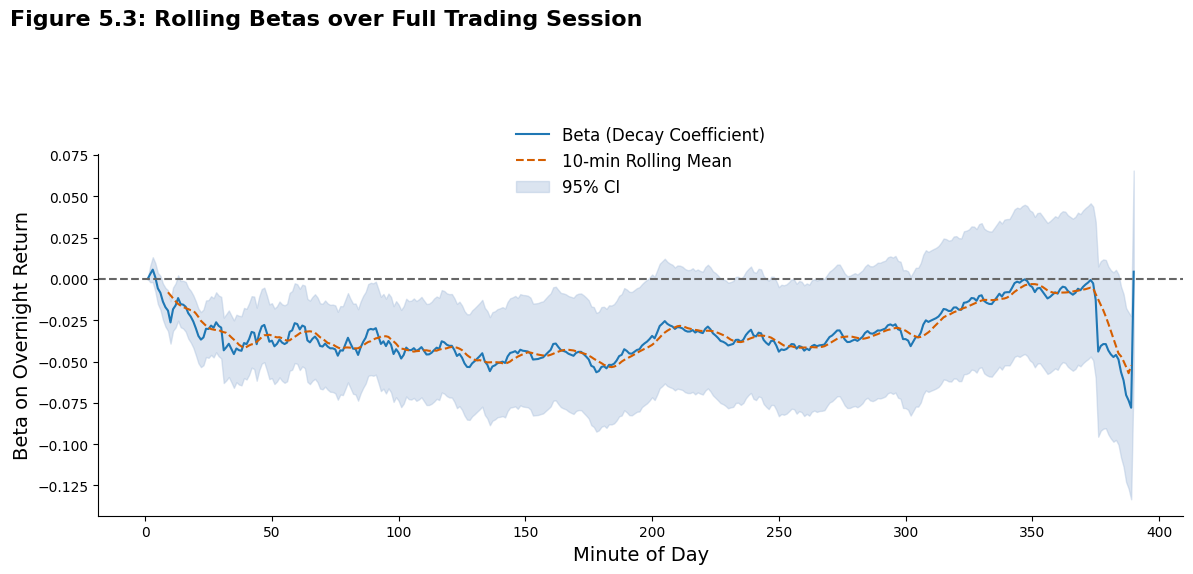

In [ ]:

# Ensure sorting and minute indexing
df_minute_all = df_minute_all.sort_values(['Symbol', 'date', 'Datetime'])
df_minute_all['minute_index'] = df_minute_all.groupby(['Symbol', 'date']).cumcount() + 1
df_reg = df_minute_all.dropna(subset=['overnight_return'])

# Regression betas by minute
def compute_betas_and_cis(df):
    betas = []
    stderr = []
    for minute in range(1, 391):
        df_minute = df[df['minute_index'] == minute]
        if df_minute.empty:
            betas.append(np.nan)
            stderr.append(np.nan)
            continue
        X = sm.add_constant(df_minute['overnight_return'])
        y = df_minute['cum_return']
        model = sm.OLS(y, X).fit()
        betas.append(model.params['overnight_return'])
        stderr.append(model.bse['overnight_return'])
    return np.array(betas), np.array(stderr)

betas_390, stderr = compute_betas_and_cis(df_reg)

# Confidence bands
minutes = np.arange(1, 391)
lower_bound = betas_390 - 2 * stderr
upper_bound = betas_390 + 2 * stderr

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(minutes, betas_390, color='#1f77b4', label='Beta (Decay Coefficient)')
ax.plot(pd.Series(betas_390).rolling(10).mean(), label='10-min Rolling Mean', color='#d55e00', linestyle='--')
ax.fill_between(minutes, lower_bound, upper_bound, color='#a6bddb', alpha=0.4, label='95% CI')
ax.axhline(0, linestyle='--', color='#666666')

# Axes labels
ax.set_xlabel('Minute of Day', fontsize=14)
ax.set_ylabel('Beta on Overnight Return', fontsize=14)

# Left-aligned figure title
fig.suptitle('Figure 5.3: Rolling Betas over Full Trading Session',
             x=0.01, ha='left', fontsize=16, fontweight='bold')

# Legend
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=1,
    frameon=False,
    fontsize=12,
    borderaxespad=0.5
)

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.grid(False)

# Caption
#fig.text(
#    0.5, -0.05,
#    "Predictive power of overnight returns declines throughout the trading session, as shown by minute-by-minute regression betas with confidence bands and smoothed trend.",
#    wrap=True, horizontalalignment='center', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()


**Calculate Distortion Factor:**

* Use the **Frobenius norm** of the difference:

  $$
  \text{Distortion Factor} = \frac{\|\text{corr_with_open} - \text{corr_without_open}\|_F}{\|\text{corr_with_open}\|_F}
  $$



The distortion factor captures **how different the correlation structure** becomes when the opening minute is included — which can be disproportionately noisy due to overnight gaps, market reactions, or illiquidity.



In [ ]:

def compute_intraday_returns(group):
    if group.shape[0] < 2:
        return pd.Series({'Return_with': np.nan, 'Return_without': np.nan})

    open_1 = group[group['minute'] == 1]['Open']
    close_last = group[group['minute'] == group['minute'].max()]['Close']
    if open_1.empty or close_last.empty:
        return pd.Series({'Return_with': np.nan, 'Return_without': np.nan})

    ret_with = (close_last.values[0] / open_1.values[0]) - 1

    group_2_last = group[group['minute'] >= 2]
    if group_2_last.empty:
        return pd.Series({'Return_with': ret_with, 'Return_without': np.nan})

    open_2 = group_2_last.iloc[0]['Open']
    close_2_last = group_2_last.iloc[-1]['Close']
    ret_without = (close_2_last / open_2) - 1

    return pd.Series({'Return_with': ret_with, 'Return_without': ret_without})

def compute_distortion(df_minute_all, max_minute):
    # Filter by session length
    df_window = df_minute_all[df_minute_all['minute'] <= max_minute].copy()
    df_window = df_window.sort_values(['Symbol', 'local_date', 'minute'])

    # Apply return computation
    returns_df = df_window.groupby(['Symbol', 'local_date']).apply(compute_intraday_returns).dropna()

    # Pivot to wide format
    pivot_with = returns_df['Return_with'].unstack().T
    pivot_without = returns_df['Return_without'].unstack().T

    pivot_with = pivot_with.dropna()
    pivot_without = pivot_without.loc[pivot_with.index, pivot_with.columns]
    pivot_with = pivot_with.loc[:, pivot_with.std() > 1e-6]
    pivot_without = pivot_without[pivot_with.columns]

    # Correlation matrices
    corr_with = pivot_with.corr()
    corr_without = pivot_without.corr()

    valid_symbols = corr_with.columns[~corr_with.isna().any()]
    corr_with_clean = corr_with.loc[valid_symbols, valid_symbols]
    corr_without_clean = corr_without.loc[valid_symbols, valid_symbols]

    if not corr_with_clean.empty and not corr_without_clean.empty:
        fro_diff = np.linalg.norm(corr_with_clean.values - corr_without_clean.values, ord='fro')
        fro_base = np.linalg.norm(corr_with_clean.values, ord='fro')
        distortion = fro_diff / fro_base
        return distortion
    else:
        return np.nan

# Compute distortion for both windows
distortion_30min = compute_distortion(df_minute_all, 30)
distortion_60min = compute_distortion(df_minute_all, 60)
distortion_90min = compute_distortion(df_minute_all, 90)
distortion_120min = compute_distortion(df_minute_all, 120)
distortion_full = compute_distortion(df_minute_all, 390)

result_df = []
result_df.append(['30 Minutes', round(distortion_30min, 3)])
result_df.append(['60 Minutes', round(distortion_60min, 3)])
result_df.append(['90 Minutes', round(distortion_90min, 3)])
result_df.append(['120 Minutes', round(distortion_120min, 3)])
result_df.append(['390 Minutes', round(distortion_full, 3)])

headers = ['Data Scope', 'Distortion Factor']
print(tabulate(result_df, headers=headers, tablefmt='grid', showindex=False)) # github


+--------------+---------------------+
| Data Scope   |   Distortion Factor |
+==============+=====================+
| 30 Minutes   |               0.191 |
+--------------+---------------------+
| 60 Minutes   |               0.208 |
+--------------+---------------------+
| 90 Minutes   |               0.159 |
+--------------+---------------------+
| 120 Minutes  |               0.153 |
+--------------+---------------------+
| 390 Minutes  |               0.129 |
+--------------+---------------------+


Implementing Mean Reversion Strategy - Long Decile 0 (Lossers)  and short Decile 9 (Winners)

In [ ]:

def compute_decile_gap(df, exclude_minute_1=False):
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=['decile', 'intraday_return'])

    if exclude_minute_1:
        df_copy = df_copy[df_copy['minute'] > 1]
        print("Number of rows after filtering:", len(df_copy))

    # Group by date and decile, compute mean intraday return
    daily_returns = df_copy.groupby(['date', 'decile'])['intraday_return'].mean().unstack()
    daily_returns['decile_gap'] = daily_returns[0] - daily_returns[9]

    # Drop NaNs for analysis
    gap_series = daily_returns['decile_gap'].dropna()

    # Statistical metrics
    t_stat, p_val = ttest_1samp(gap_series, 0)
    summary = gap_series.describe()

    # Cumulative return
    cumulative_return = (1 + gap_series).prod() - 1

    # Sharpe ratio (assuming mean and std over daily returns)
    sharpe_ratio = gap_series.mean() / gap_series.std()

    return gap_series, {
        'N': len(gap_series),
        'Mean': summary['mean'],
        'Std': summary['std'],
        'T-Stat': t_stat,
        'P-Value': p_val,
        'Cumulative Return': cumulative_return,
        'Sharpe': sharpe_ratio
    }

# Compute both versions
series_with, stats_with = compute_decile_gap(df_minute_all, exclude_minute_1=False)
series_without, stats_without = compute_decile_gap(df_minute_all, exclude_minute_1=True)

# Tabulate results
table = [
    ['With Minute 1',
     stats_with['N'],
     round(stats_with['Mean'], 4),
     round(stats_with['T-Stat'], 3),
     round(stats_with['P-Value'], 4),
     round(stats_with['Cumulative Return'], 4),
     round(stats_with['Sharpe'], 3)],

    ['Without Minute 1',
     stats_without['N'],
     round(stats_without['Mean'], 4),
     round(stats_without['T-Stat'], 3),
     round(stats_without['P-Value'], 4),
     round(stats_without['Cumulative Return'], 4),
     round(stats_without['Sharpe'], 3)]
]

headers = ['Version', 'N', 'Mean Return', 'T-Stat', 'P-Value', 'Cumulative Return', 'Sharpe Ratio']
print(tabulate(table, headers=headers, tablefmt='grid'))


Number of rows after filtering: 1424293
+------------------+-----+---------------+----------+-----------+---------------------+----------------+
| Version          |   N |   Mean Return |   T-Stat |   P-Value |   Cumulative Return |   Sharpe Ratio |
+==================+=====+===============+==========+===========+=====================+================+
| With Minute 1    | 431 |        0.0028 |    5.956 |         0 |              2.2499 |          0.287 |
+------------------+-----+---------------+----------+-----------+---------------------+----------------+
| Without Minute 1 | 431 |        0.0028 |    5.956 |         0 |              2.2499 |          0.287 |
+------------------+-----+---------------+----------+-----------+---------------------+----------------+


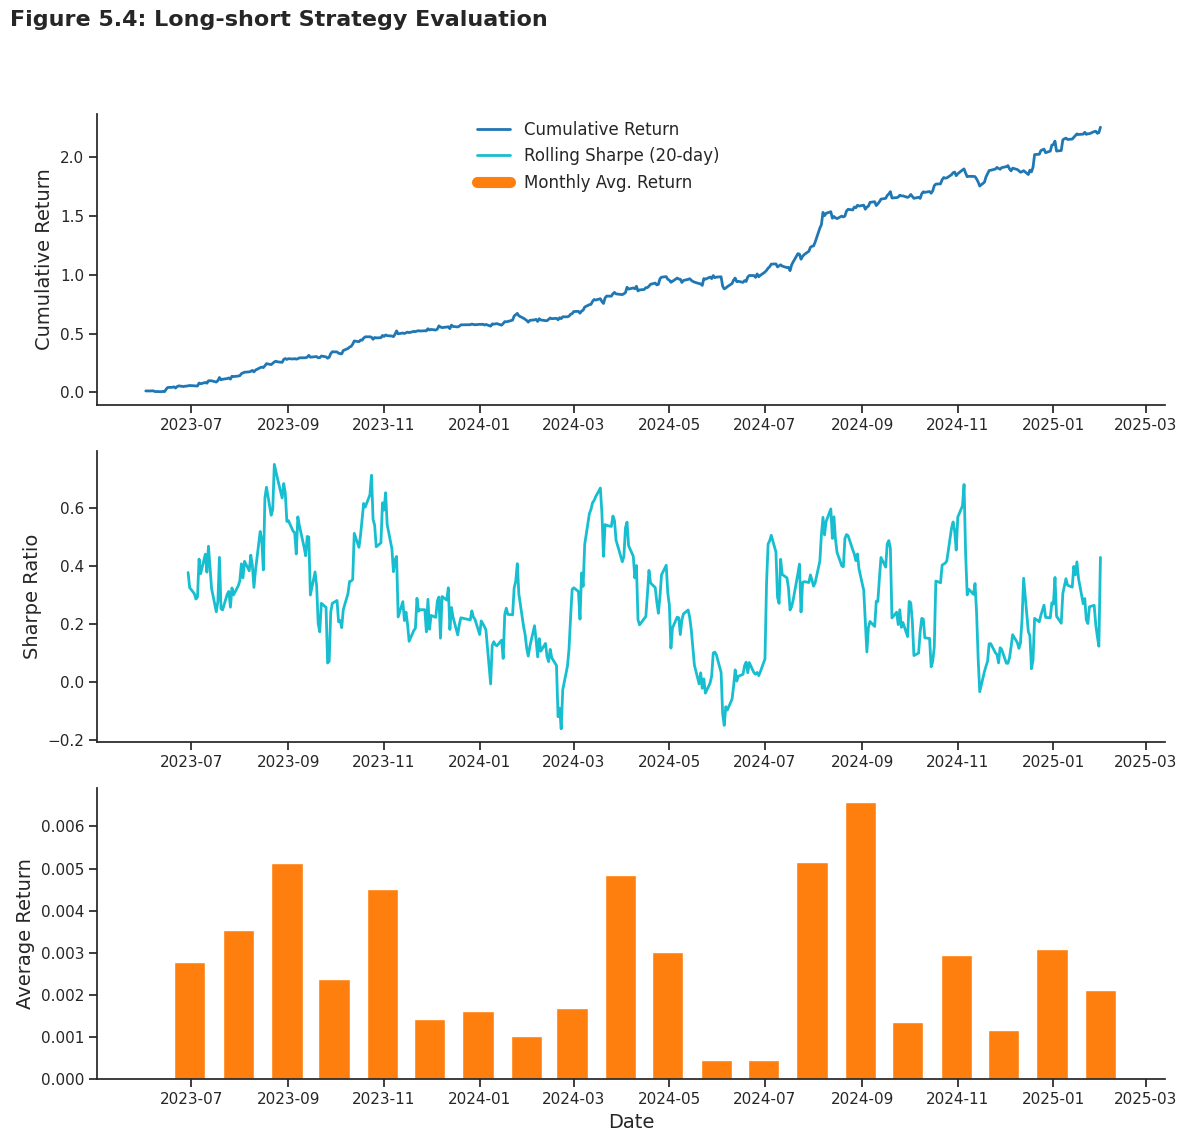

In [ ]:
# Prepare decile returns
gap_series = series_with.copy().sort_index()
decile_returns = pd.DataFrame({'decile_gap': gap_series})
decile_returns.index = pd.to_datetime(decile_returns.index)

# Compute performance metrics
decile_returns['cumulative_return'] = (1 + decile_returns['decile_gap']).cumprod() - 1
rolling_window = 20
decile_returns['rolling_sharpe'] = (
    decile_returns['decile_gap'].rolling(window=rolling_window).mean() /
    decile_returns['decile_gap'].rolling(window=rolling_window).std()
)
monthly_returns = decile_returns['decile_gap'].resample('M').mean()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

def clean_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.grid(False)

# Cumulative Return
axes[0].plot(decile_returns.index, decile_returns['cumulative_return'],
             color='#1f77b4', linewidth=2, label='Cumulative Return')
axes[0].set_ylabel('Cumulative Return', fontsize=14)
clean_axes(axes[0])

# Rolling Sharpe Ratio
axes[1].plot(decile_returns.index, decile_returns['rolling_sharpe'],
             color='#17becf', linewidth=2, label='Rolling Sharpe (20-day)')
axes[1].set_ylabel('Sharpe Ratio', fontsize=14)
clean_axes(axes[1])

# Monthly Average Return
axes[2].bar(monthly_returns.index, monthly_returns.values,
            width=20, color='#ff7f0e', label='Monthly Avg. Return')
axes[2].set_ylabel('Average Return', fontsize=14)
axes[2].set_xlabel('Date', fontsize=14)
clean_axes(axes[2])

# Unified figure title (left-aligned)
fig.suptitle('Figure 5.4: Long-short Strategy Evaluation',
             x=0.01, ha='left', fontsize=16, fontweight='bold')

# Central legend above all plots
handles = [line for ax in axes for line in ax.get_lines()]
labels = [line.get_label() for ax in axes for line in ax.get_lines()]
bar_patch = plt.Line2D([0], [0], color='#ff7f0e', lw=8, label='Monthly Avg. Return')
handles.append(bar_patch)
labels.append('Monthly Avg. Return')

fig.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=1, fontsize=12, frameon=False)

# Caption
#fig.text(0.5, -0.02,
#         'Long-short strategy performance shows steady cumulative gains, stable risk-adjusted returns (rolling Sharpe), and consistent monthly returns, underscoring robustness.',
#        wrap=True, horizontalalignment='center', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()


More Results

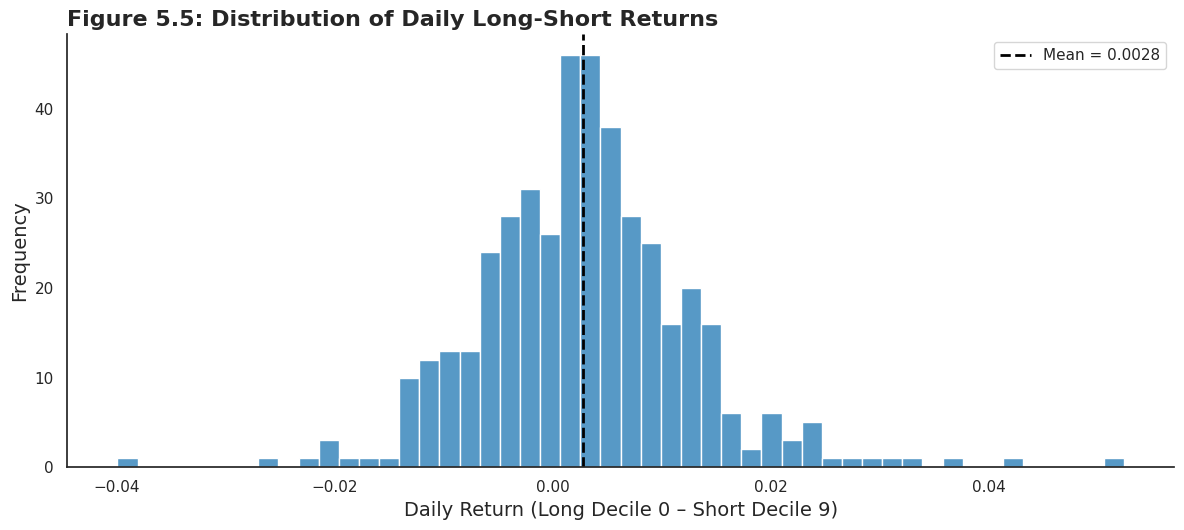

In [ ]:

sns.set(style='white')  # No gridlines

plt.figure(figsize=(12, 6))

# Plot histogram and mean line
sns.histplot(series_with, bins=50, color='#1f77b4', kde=False)
plt.axvline(series_with.mean(), color='black', linestyle='--', linewidth=2,
            label=f"Mean = {series_with.mean():.4f}")
plt.xlabel('Daily Return (Long Decile 0 – Short Decile 9)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Figure 5.5: Distribution of Daily Long-Short Returns',
          fontsize=16, fontweight='bold', loc='left')
plt.legend()

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Retain only left and bottom axis lines
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.grid(False)

# Caption
#plt.figtext(
#    0.5, -0.05,
#    'Histogram of daily long-short returns reveals a slightly left-skewed distribution with a positive mean, consistent with mean-reversion expectations.',
#wrap=True, horizontalalignment='center', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()



In [ ]:

pos_ratio = (series_with > 0).mean()
print(f"Fraction of days with positive long-short return: {pos_ratio:.2%}")


Fraction of days with positive long-short return: 63.11%
